# TSMixer: Forecast

- load trained models
- compute ensemble
- export in submission format

### Setup

In [48]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [49]:
from darts.models import TSMixerModel

### Configuration

In [50]:
NUM_SAMPLES = 1000
HORIZON = 4

# Load data

In [51]:
ts_are = load_target_series('are')
ts_sari = load_target_series('sari')
target_series, covariates = retain_period_common_to_all([ts_sari, ts_are])

In [52]:
RANDOM_SEEDS = [1, 2, 3, 4, 5] # , 6, 7, 8, 9, 10]

In [53]:
NAME = 'tsmixer'

In [54]:
NAME = 'tsmixer2'

In [55]:
NAME = 'tsmixer_noCov'

In [56]:
forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [46]:
def compute_ensemble(forecast_date, export=False):
    dfs = []
    for seed in RANDOM_SEEDS:
        print(seed)
        model_path = f'../models/post-covid/post-covid_{NAME}-{seed}.pt'
        model = TSMixerModel.load(model_path)
        df = compute_forecast(model, target_series, None, forecast_date, HORIZON, NUM_SAMPLES, vincentization=True, probabilistic_nowcast=True, local=True)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

    df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])
    
    if export:
        df.to_csv(f'../data/post-covid/submissions/{forecast_date}-icosari-sari-DW-{NAME}.csv', index=False)
        return df
    else:
        return df

In [11]:
df = compute_ensemble(forecast_dates[5])

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:02 • 0:00:00 0.00it/s

In [ ]:
forecasts = []
for forecast_date in forecast_dates[4:]:
    print(forecast_date)
    forecast = compute_ensemble(forecast_date, export=True)
    forecasts.append(forecast)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/1 0:00:00 • -:--:-- 0.00it/s

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


# Plot forecasts

In [57]:
df = pd.concat(forecasts)

In [58]:
target_sari = load_target_series('sari')

In [59]:
df_plot = prepare_plot_data(df, target_sari)

### no covariates

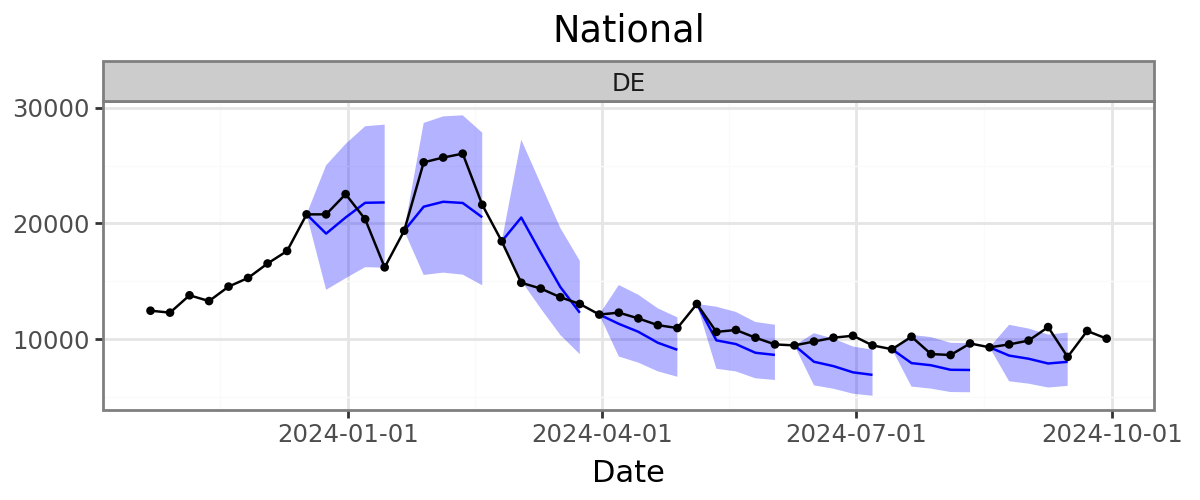

In [60]:
plot_forecasts(df_plot, 'national', start=1)

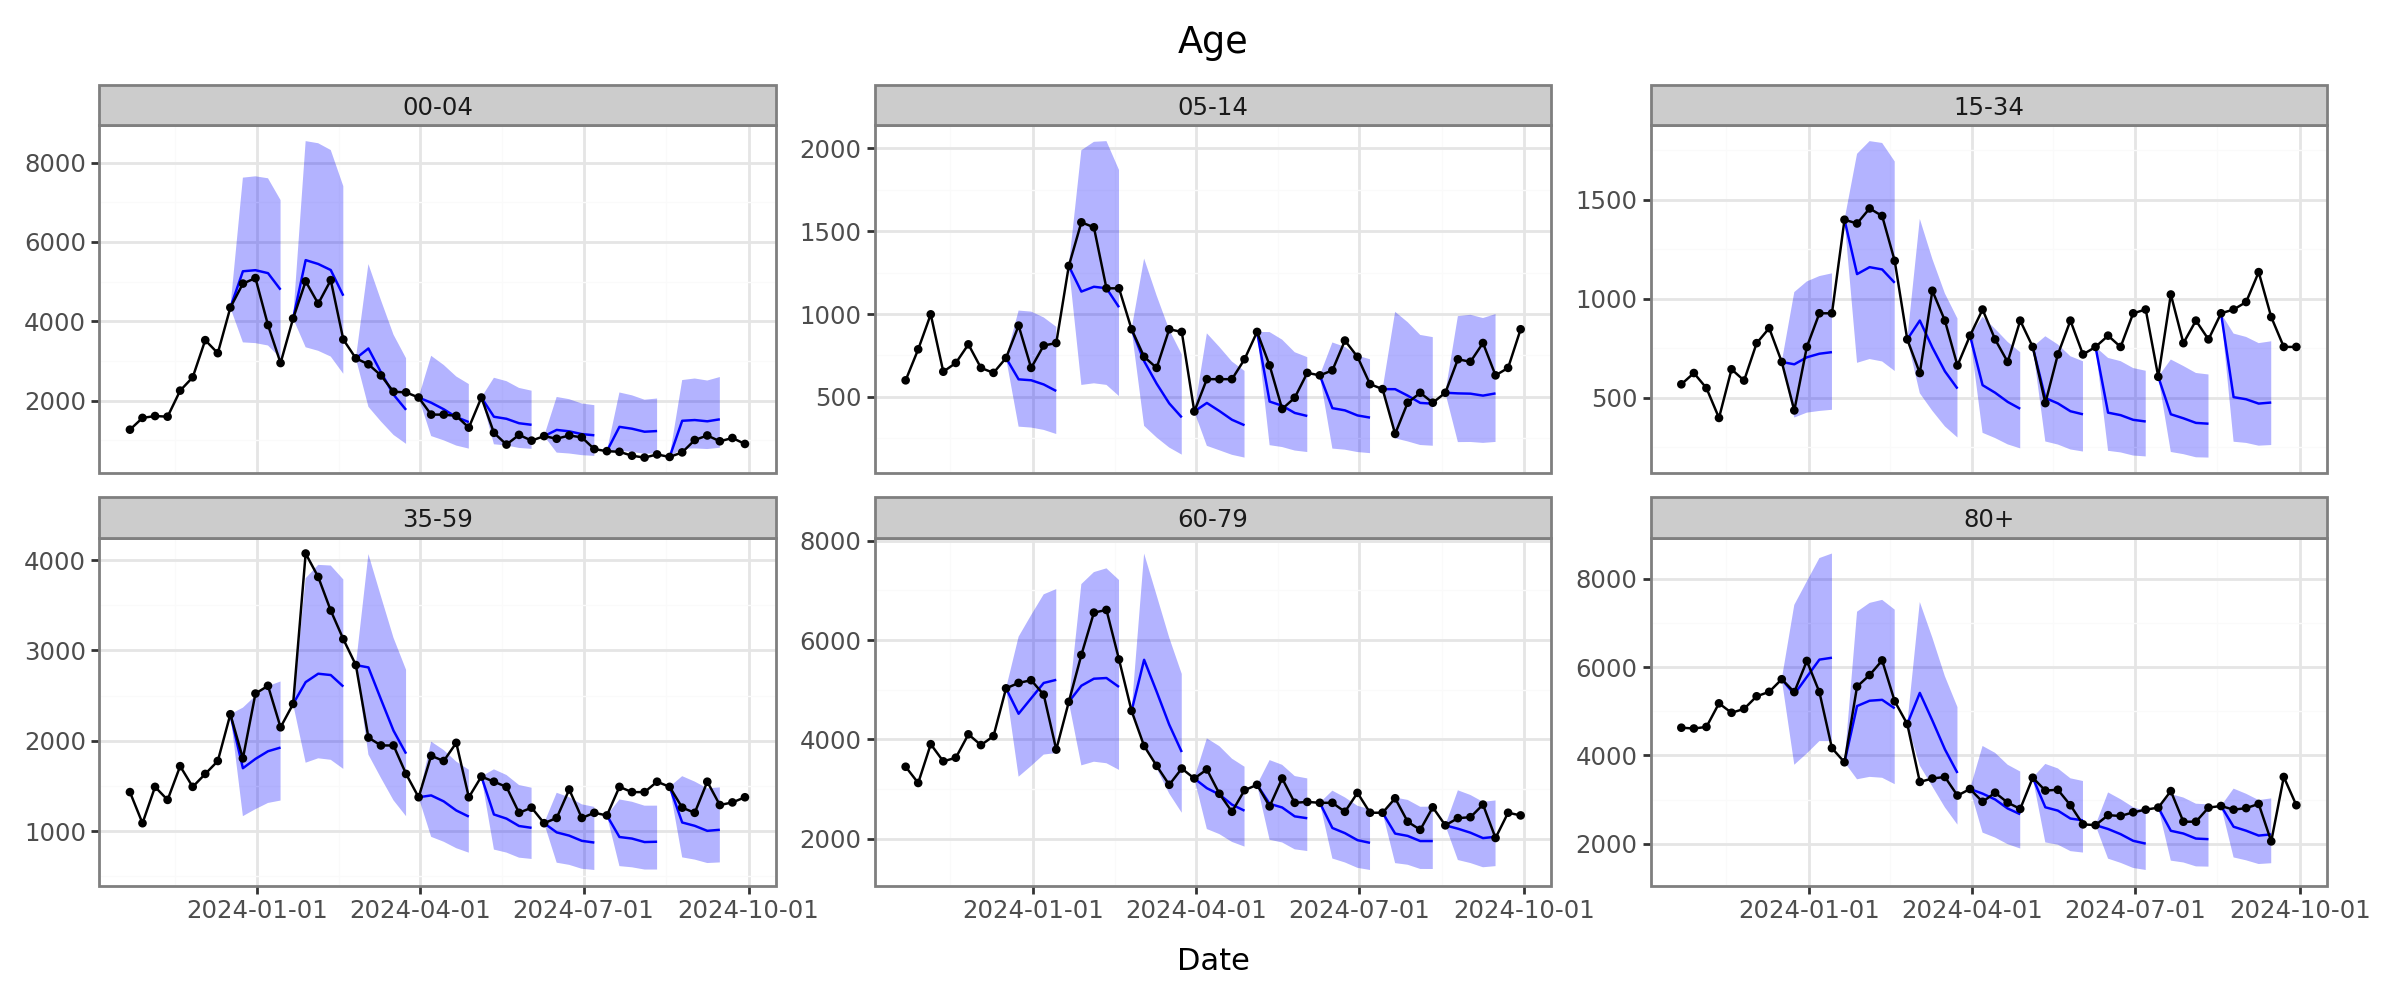

In [62]:
plot_forecasts(df_plot, 'age', start=1)

### tsmixer2

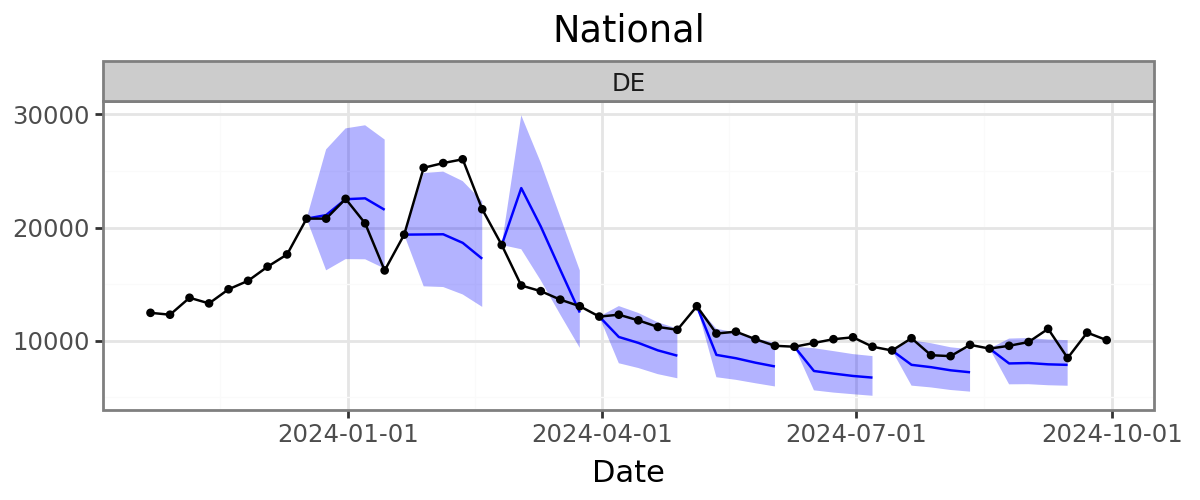

In [34]:
plot_forecasts(df_plot, 'national', start=1)

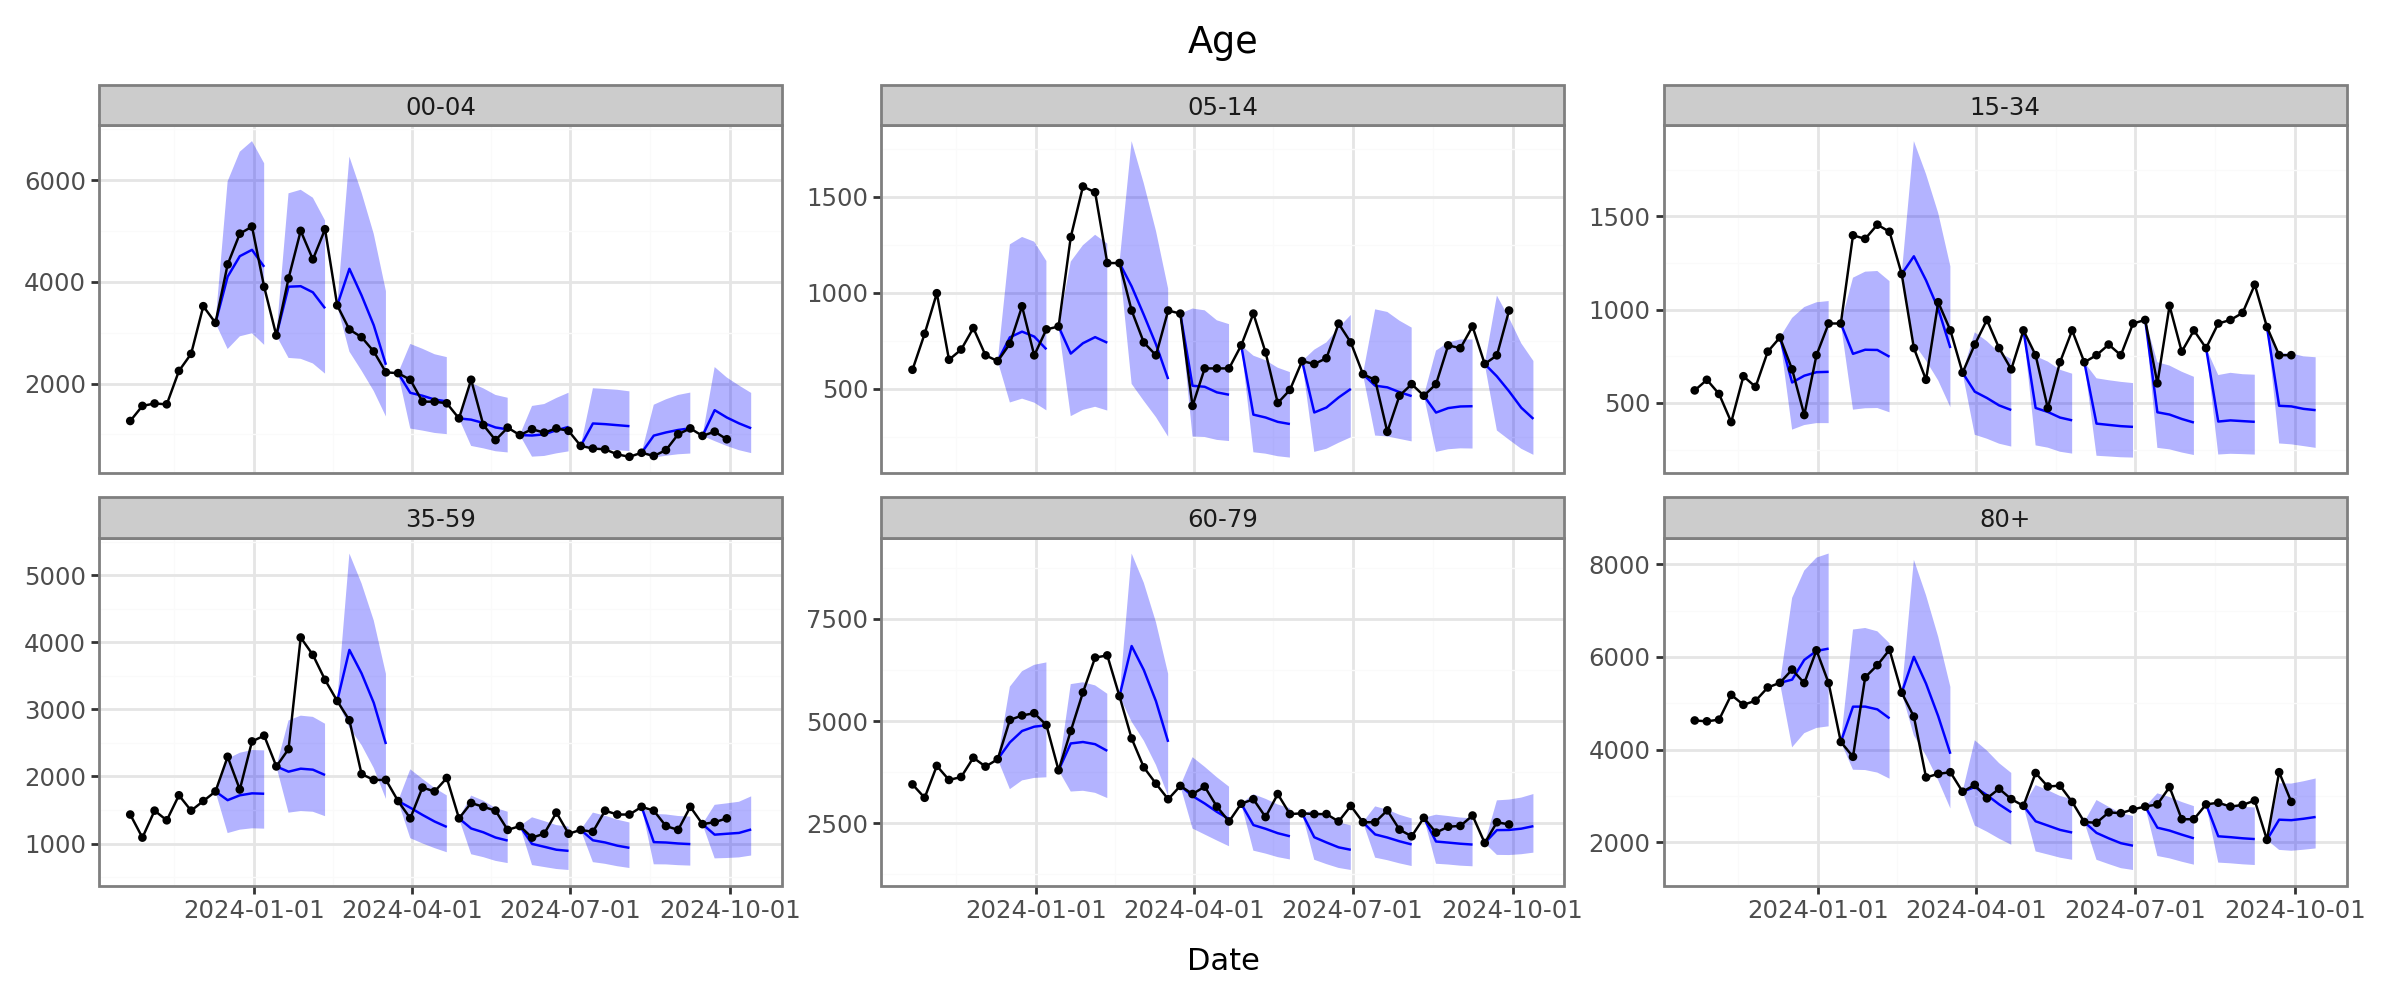

In [36]:
plot_forecasts(df_plot, 'age', start=0)

### tsmixer

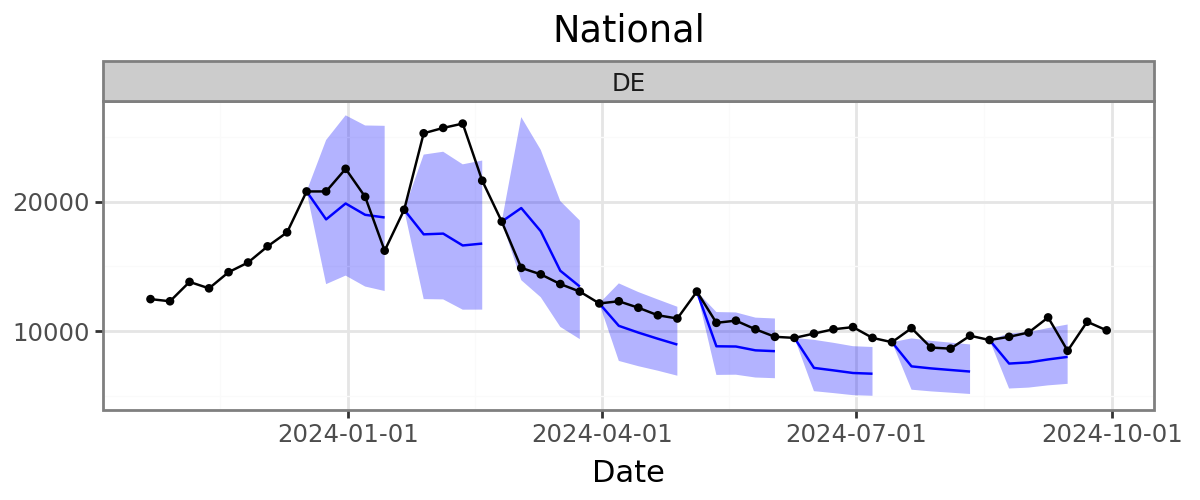

In [18]:
plot_forecasts(df_plot, 'national', start=1)

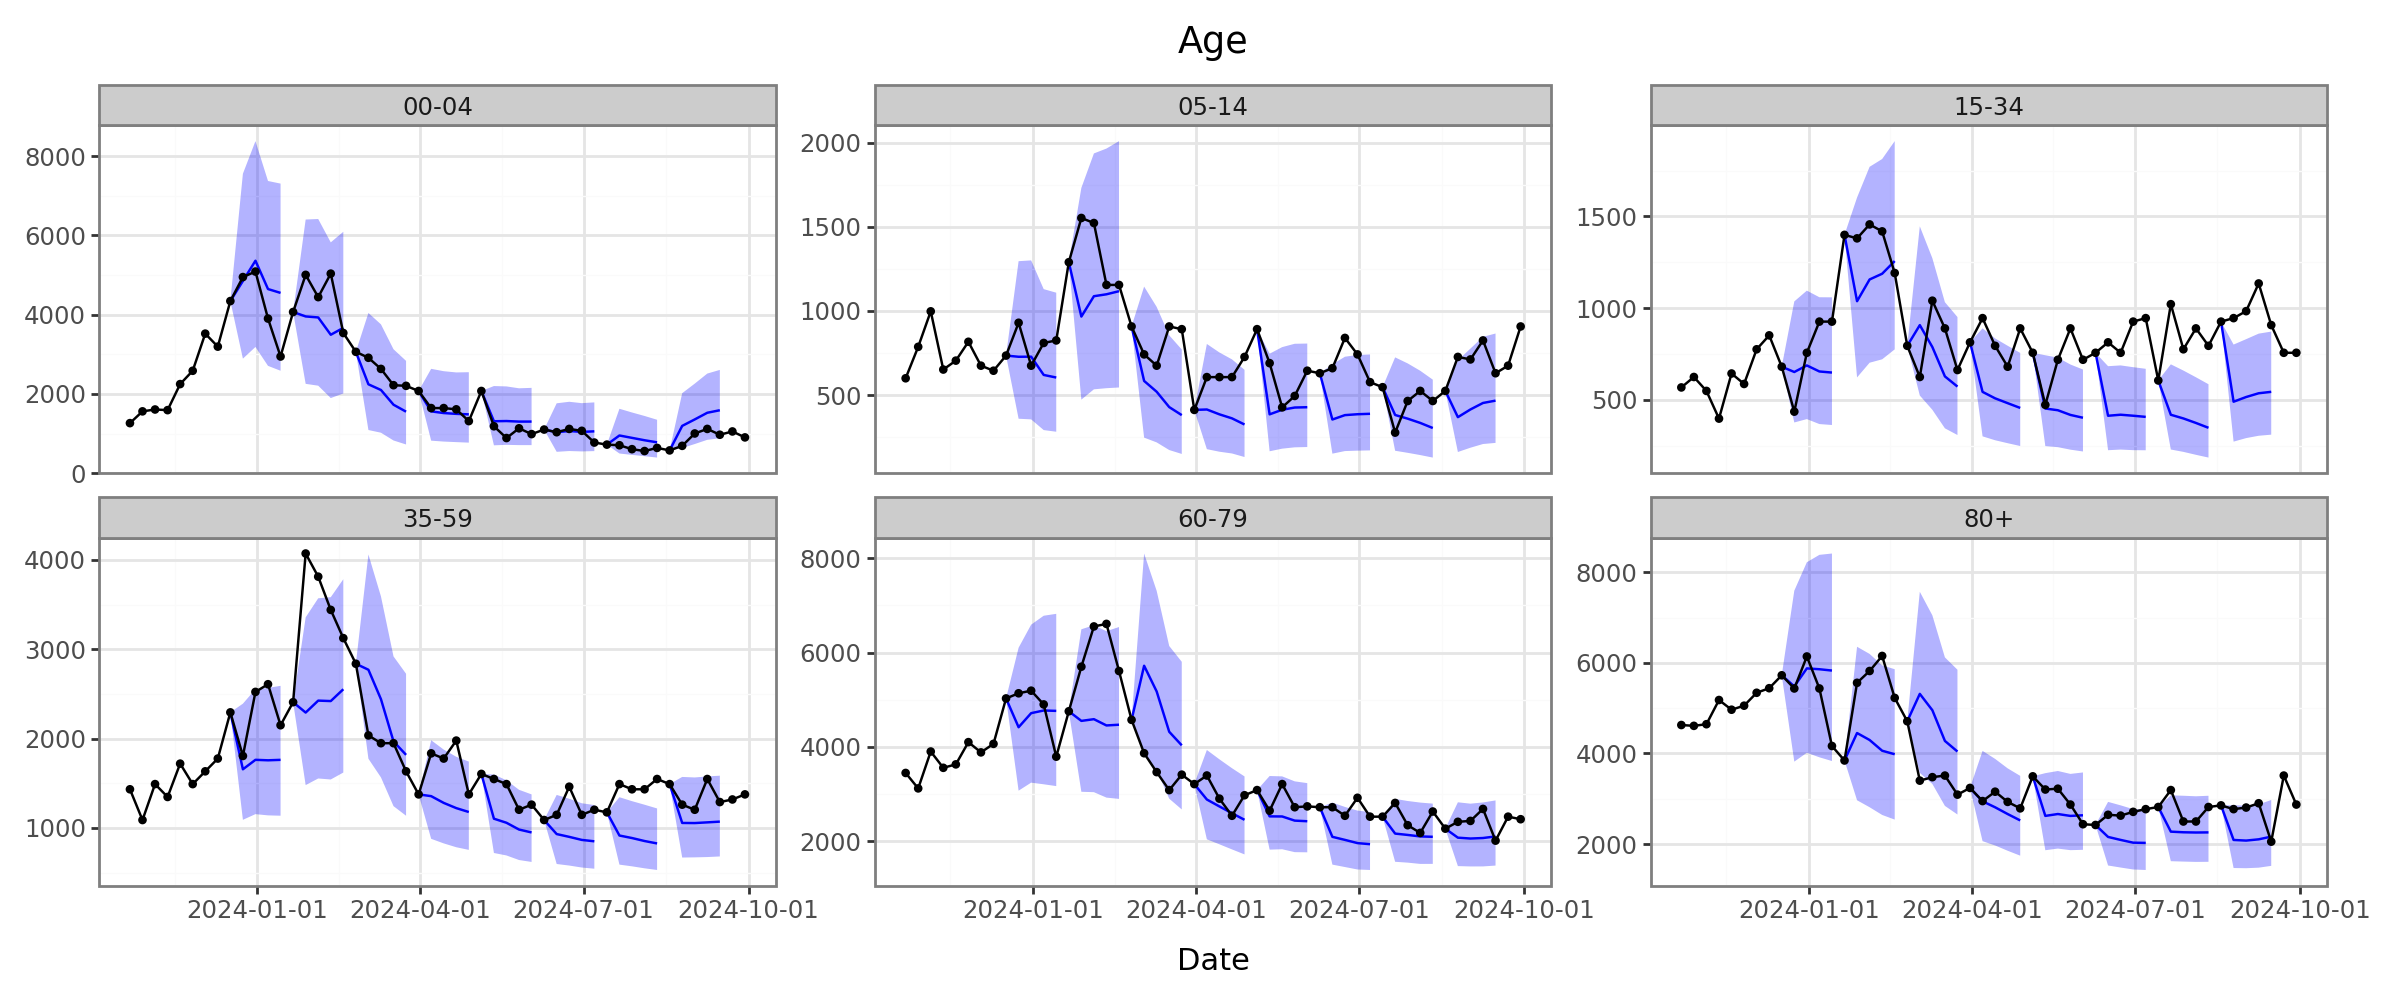

In [21]:
plot_forecasts(df_plot, 'age', start=1)